In [23]:
import pandas as pd
import numpy as np
import wfdb
import ast
from itertools import chain
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import acf

### Загрузка данных

In [2]:
df = pd.read_csv('plt/ptbxl_database.csv')
df.head()

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr


In [58]:
df['heart_axis'].value_counts(dropna=False)

NaN     8468
MID     7687
LAD     3764
ALAD    1382
RAD      221
ARAD     122
AXL      101
AXR       51
SAG        3
Name: heart_axis, dtype: int64

In [5]:
path = 'plt/records500'
example = wfdb.rdsamp(path + '/00000/00001_hr')

In [6]:
main_lines = example[0].T[:6]

In [17]:
example[0][:, :6].shape

(5000, 6)

### Свертка 6 отведений в 2 измерения

In [18]:
pca = PCA(n_components=2)
pca.fit(example[0][:, :6])

PCA(n_components=2)

In [20]:
np.sum(pca.explained_variance_ratio_)

0.9999901807685847

In [22]:
pca.components_.T

array([[ 0.60260166,  0.1352525 ],
       [ 0.41833954, -0.45408546],
       [-0.184295  , -0.58926638],
       [-0.51001382,  0.16150573],
       [ 0.39266456,  0.36370696],
       [ 0.11661501, -0.51953002]])

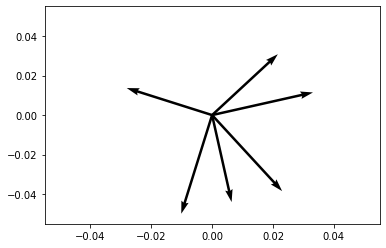

In [32]:
plt.quiver(*np.array([[0] * 6,[0] * 6]), pca.components_.T[:, 0], pca.components_.T[:, 1], scale=2)

### Сжатие других отведений

In [34]:
chest_leads = example[0][:, 6:]
chest_leads.shape

(5000, 6)

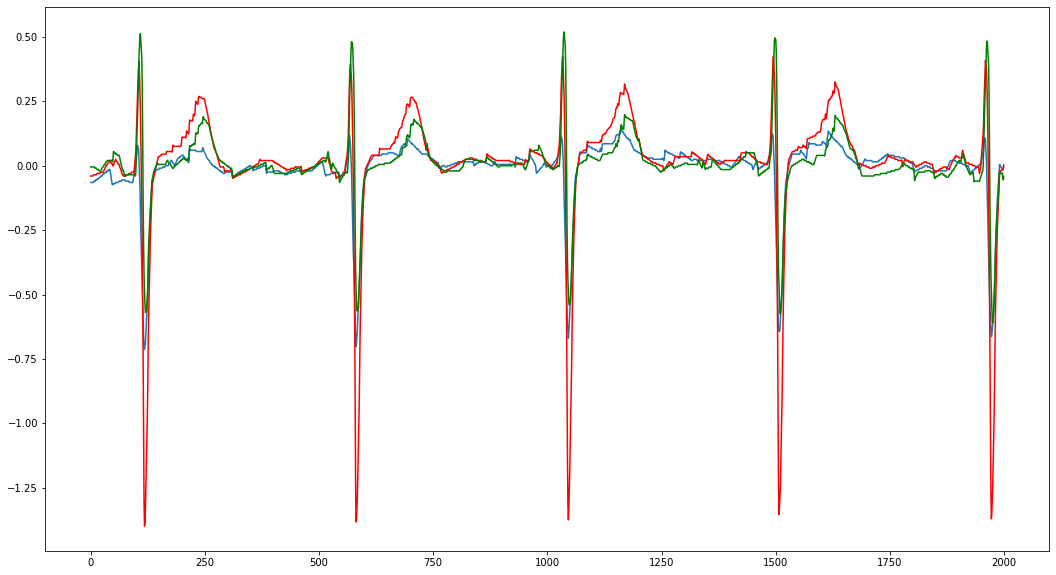

In [46]:
plt.figure(figsize=(18, 10))
plt.plot(range(2000), chest_leads.T[0][:2000])
plt.plot(range(2000), chest_leads.T[1][:2000], color='r')
plt.plot(range(2000), chest_leads.T[2][:2000], color='g')

In [47]:
chest_pca = PCA(n_components=4)
chest_pca.fit(chest_leads)

PCA(n_components=4)

In [48]:
np.sum(chest_pca.explained_variance_ratio_)

0.9962872362882456

In [54]:
def crosscorr(x, y, lag):
    return pd.Series(x).corr(pd.Series(y).shift(lag))

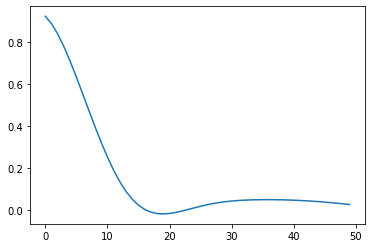

In [55]:
corr = [crosscorr(chest_leads.T[0], chest_leads.T[1], i) for i in range(0, 50)]
plt.plot(range(0, 50), corr)

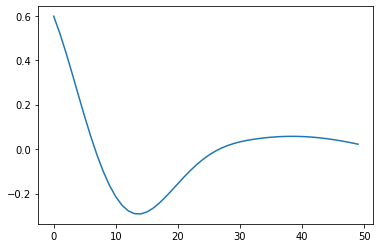

In [59]:
corr = [crosscorr(chest_leads.T[0], chest_leads.T[2], i) for i in range(0, 50)]
plt.plot(range(0, 50), corr)

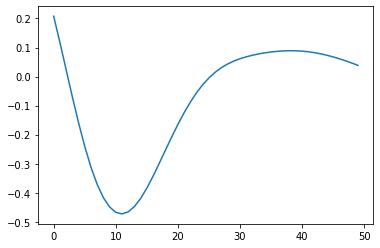

In [60]:
corr = [crosscorr(chest_leads.T[0], chest_leads.T[3], i) for i in range(0, 50)]
plt.plot(range(0, 50), corr)

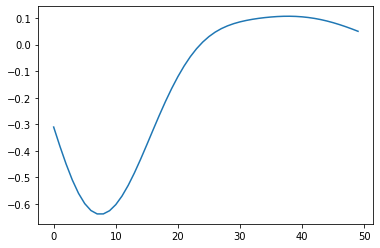

In [61]:
corr = [crosscorr(chest_leads.T[0], chest_leads.T[4], i) for i in range(0, 50)]
plt.plot(range(0, 50), corr)

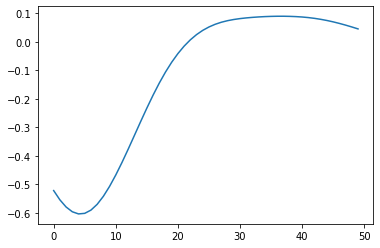

In [62]:
corr = [crosscorr(chest_leads.T[0], chest_leads.T[5], i) for i in range(0, 50)]
plt.plot(range(0, 50), corr)

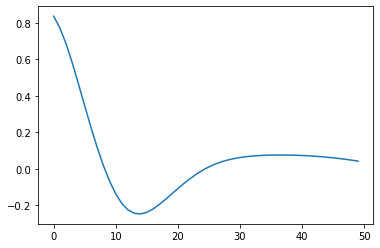

In [63]:
corr = [crosscorr(chest_leads.T[1], chest_leads.T[2], i) for i in range(0, 50)]
plt.plot(range(0, 50), corr)

Как видно, грудные отведения линейно не зависимы а также уровень корелляции с лагом низок